In [ ]:
%pip install torch-geometric

In [1]:
import os
import time
import psutil
import random
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader

In [2]:
random_seed = 42

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(random_seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

using cpu


# Graph Classification

## Dataset Preparation

In [ ]:
# Load the MUTAG dataset
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')
# print(len(dataset))

# Split the dataset into train and test sets
train_dataset = dataset[:150]
test_dataset = dataset[150:]

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get the number of features and classes from the dataset
num_features = train_dataset.num_features
num_classes = train_dataset.num_classes

## GCN Model

In [4]:
class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [5]:
def train_gcn(model, loader, lr=0.001, num_epochs=100, save_path='models/gcn_x.pth'):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    training_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []    
    
    # Train and test the models
    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()
        
        for data in loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * data.num_graphs
    
        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')
        

    # Plot the training loss
    plt.plot(training_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

    print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
    print(f'Average CPU Usage: {np.mean(cpu_usage):.2f}GB')
    print(f'Average Memory Usage: {np.mean(memory_usage):.2f}GB')

    print(f'\nTotal Training Time: {np.sum(epoch_time):.2f}s')
    print(f'Max CPU Usage: {np.max(cpu_usage):.2f}GB')
    print(f'Max Memory Usage: {np.max(memory_usage):.2f}GB')

    return 


def evaluate_gcn(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    
    return accuracy, sensitivity, specificity


def test_gcn(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            output = model(data)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate_gcn(y_true, y_pred)
    return 

GCN1Layer(
  (conv1): GCNConv(7, 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 1284

Epoch 1, Loss: 102.5046033859253
Time: 0.08s, CPU: 1.27GB, Memory: 2.73GB
Epoch 2, Loss: 95.1695408821106
Time: 0.01s, CPU: 2.29GB, Memory: 2.73GB
Epoch 3, Loss: 94.8461743593216
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 4, Loss: 93.1758029460907
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 5, Loss: 92.04147505760193
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 6, Loss: 90.60125494003296
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 7, Loss: 88.98138463497162
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 8, Loss: 87.3537746667862
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 9, Loss: 85.71582448482513
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 10, Loss: 83.98720741271973
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 11, Loss: 82.48292684555054
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 12, Loss: 81.3107031583786
Time: 0.01s, C

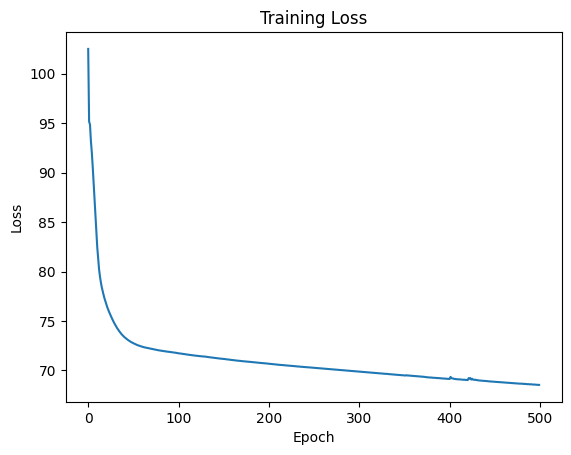

Model saved to models/gcn_1l.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.12GB
Average Memory Usage: 2.70GB

Total Training Time: 4.12s
Max CPU Usage: 3.55GB
Max Memory Usage: 2.73GB


In [29]:
# Create model instances
model1 = GCN1Layer(num_features, num_classes)
print(model1)
print(f"Total number of trainable parameters: {(model1.count_parameters())*2}\n")
train_gcn(model1, train_loader, lr=0.01, num_epochs=500, save_path='models/gcn_1l.pth')

GCN2Layer(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 9604

Epoch 1, Loss: 97.45988821983337
Time: 0.02s, CPU: 0.00GB, Memory: 2.67GB
Epoch 2, Loss: 94.18167066574097
Time: 0.02s, CPU: 0.00GB, Memory: 2.67GB
Epoch 3, Loss: 91.91665196418762
Time: 0.01s, CPU: 0.00GB, Memory: 2.67GB
Epoch 4, Loss: 88.678506731987
Time: 0.01s, CPU: 0.00GB, Memory: 2.67GB
Epoch 5, Loss: 85.87178266048431
Time: 0.01s, CPU: 0.00GB, Memory: 2.67GB
Epoch 6, Loss: 82.62450850009918
Time: 0.01s, CPU: 0.00GB, Memory: 2.67GB
Epoch 7, Loss: 80.26271158456802
Time: 0.02s, CPU: 0.00GB, Memory: 2.67GB
Epoch 8, Loss: 78.6526363492012
Time: 0.01s, CPU: 0.00GB, Memory: 2.67GB
Epoch 9, Loss: 78.20446020364761
Time: 0.01s, CPU: 0.00GB, Memory: 2.67GB
Epoch 10, Loss: 77.99987125396729
Time: 0.01s, CPU: 0.00GB, Memory: 2.67GB
Epoch 11, Loss: 77.6844899058342
Time: 0.01s, CPU: 0.00GB, Memory: 2.67GB
Epoch 12, Loss: 77.1

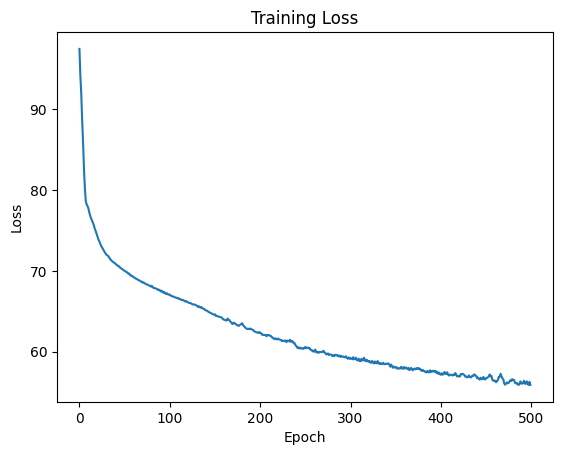

Model saved to models/gcn_2l.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.15GB
Average Memory Usage: 2.70GB

Total Training Time: 5.73s
Max CPU Usage: 6.91GB
Max Memory Usage: 2.77GB


In [30]:
model2 = GCN2Layer(num_features, num_classes)
print(model2)
print(f"Total number of trainable parameters: {(model2.count_parameters())*2}\n")
train_gcn(model2, train_loader, lr=0.01, num_epochs=500, save_path='models/gcn_2l.pth')

In [37]:
print('Model 1-Layer GCN')
model1.load_state_dict(torch.load('models/gcn_1l.pth'))
test_gcn(model1, test_loader)

print('\nModel 2-Layer GCN')
# Load the best model and evaluate on the test set
model2.load_state_dict(torch.load('models/gcn_2l.pth'))
test_gcn(model2, test_loader)

Model 1-Layer GCN
Accuracy: 0.6842
Sensitivity: 0.7692
Specificity: 0.5000

Model 2-Layer GCN
Accuracy: 0.8421
Sensitivity: 0.9615
Specificity: 0.5833


## Reservoir GCN

# Node Classification

In [8]:
# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
# transform=T.NormalizeFeatures()
data = dataset[0]

# Example of data attributes
print(data)
print("Node feature shape:", data.x.shape)
print("Edge index shape:", data.edge_index.shape)
print("Number of classes:", dataset.num_classes)
print("Number of node features:", dataset.num_node_features)

# Splitting the data into train, validation, and test sets
train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Node feature shape: torch.Size([2708, 1433])
Edge index shape: torch.Size([2, 10556])
Number of classes: 7
Number of node features: 1433


In [9]:
class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [11]:
def train_gcn(model, data, lr=0.001, num_epochs=100, save_path='models/gcn_x.pth'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    training_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []    

    for epoch in range(num_epochs):
        epoch_loss = 0
        set_seed(42)
        model.train()
        epoch_start_time = time.time()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        epoch_loss = loss.item()

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')
        

    # Plot the training loss
    plt.plot(training_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

    print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
    print(f'Average CPU Usage: {np.mean(cpu_usage):.2f}GB')
    print(f'Average Memory Usage: {np.mean(memory_usage):.2f}GB')

    print(f'\nTotal Training Time: {np.sum(epoch_time):.2f}s')
    print(f'Max CPU Usage: {np.max(cpu_usage):.2f}GB')
    print(f'Max Memory Usage: {np.max(memory_usage):.2f}GB')

    return 

def evaluate_gcn(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    
    return accuracy, sensitivity, specificity

def test_gcn(model, data, mask):
    model.eval()
    y_true = data.y[mask].tolist()
    y_pred = []

    with torch.no_grad():
        output = model(data)
        pred = output[mask].argmax(dim=1)
        y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate_gcn(y_true, y_pred)
    return accuracy

GCN1Layer(
  (conv1): GCNConv(1433, 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23063

Epoch 1, Loss: 1.961796760559082
Time: 0.01s, CPU: 0.63GB, Memory: 3.96GB
Epoch 2, Loss: 1.8811074495315552
Time: 0.01s, CPU: 2.66GB, Memory: 3.96GB
Epoch 3, Loss: 1.7949975728988647
Time: 0.01s, CPU: 0.00GB, Memory: 3.96GB
Epoch 4, Loss: 1.69119131565094
Time: 0.00s, CPU: 3.20GB, Memory: 3.96GB
Epoch 5, Loss: 1.5788600444793701
Time: 0.00s, CPU: 0.00GB, Memory: 3.96GB
Epoch 6, Loss: 1.4599337577819824
Time: 0.00s, CPU: 0.00GB, Memory: 3.96GB
Epoch 7, Loss: 1.337815761566162
Time: 0.01s, CPU: 0.00GB, Memory: 3.96GB
Epoch 8, Loss: 1.2168980836868286
Time: 0.00s, CPU: 0.00GB, Memory: 3.96GB
Epoch 9, Loss: 1.1001490354537964
Time: 0.01s, CPU: 0.00GB, Memory: 3.96GB
Epoch 10, Loss: 0.9899478554725647
Time: 0.00s, CPU: 0.00GB, Memory: 3.96GB
Epoch 11, Loss: 0.8886643052101135
Time: 0.01s, CPU: 0.00GB, Memory: 3.96GB
Epoch 12, Loss: 0.79698675870895

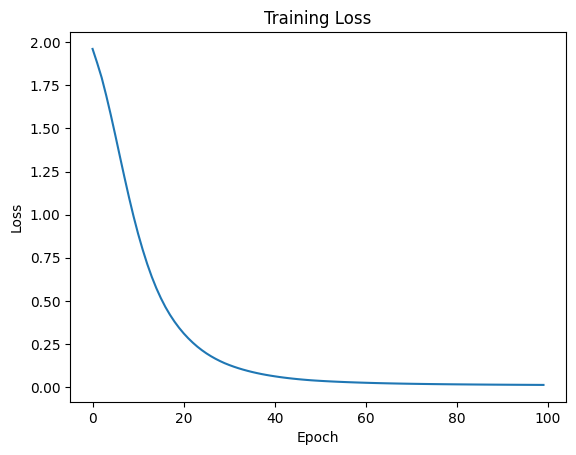

Model saved to models/gcn_1l_node.pth
Average Time per Epoch: 0.00s
Average CPU Usage: 0.06GB
Average Memory Usage: 3.96GB

Total Training Time: 0.48s
Max CPU Usage: 3.20GB
Max Memory Usage: 3.96GB


In [14]:
# Create model instances
model1 = GCN1Layer(num_features=dataset.num_node_features, num_classes=dataset.num_classes)
print(model1)
print(f"Total number of trainable parameters: {model1.count_parameters()}\n")
train_gcn(model1, data, lr=0.01, num_epochs=100, save_path='models/gcn_1l_node.pth')


GCN2Layer(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23335

Epoch 1, Loss: 1.94921875
Time: 0.01s, CPU: 1.06GB, Memory: 3.95GB
Epoch 2, Loss: 1.9185572862625122
Time: 0.01s, CPU: 3.43GB, Memory: 3.95GB
Epoch 3, Loss: 1.8801110982894897
Time: 0.01s, CPU: 0.00GB, Memory: 3.95GB
Epoch 4, Loss: 1.8288681507110596
Time: 0.01s, CPU: 1.00GB, Memory: 3.95GB
Epoch 5, Loss: 1.7696020603179932
Time: 0.01s, CPU: 0.00GB, Memory: 3.95GB
Epoch 6, Loss: 1.7013170719146729
Time: 0.01s, CPU: 0.00GB, Memory: 3.95GB
Epoch 7, Loss: 1.6264441013336182
Time: 0.01s, CPU: 0.00GB, Memory: 3.95GB
Epoch 8, Loss: 1.5455316305160522
Time: 0.01s, CPU: 0.00GB, Memory: 3.95GB
Epoch 9, Loss: 1.4593141078948975
Time: 0.01s, CPU: 0.00GB, Memory: 3.95GB
Epoch 10, Loss: 1.367380142211914
Time: 0.01s, CPU: 0.00GB, Memory: 3.95GB
Epoch 11, Loss: 1.2712100744247437
Time: 0.01s, CPU: 0.00GB, Memory: 3.95GB
Epoch 12, 

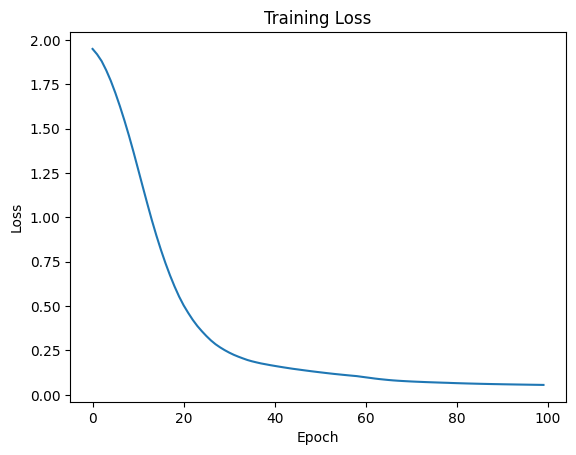

Model saved to models/gcn_2l_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.05GB
Average Memory Usage: 3.95GB

Total Training Time: 0.74s
Max CPU Usage: 3.43GB
Max Memory Usage: 3.95GB


In [15]:

model2 = GCN2Layer(num_features=dataset.num_node_features, num_classes=dataset.num_classes)
print(model2)
print(f"Total number of trainable parameters: {model2.count_parameters()}\n")
train_gcn(model2, data, lr=0.01, num_epochs=100, save_path='models/gcn_2l_node.pth')

In [16]:
print('Model 1-Layer GCN')
model1.load_state_dict(torch.load('models/gcn_1l_node.pth'))
test_gcn(model1, data, data.test_mask)

print('\nModel 2-Layer GCN')
model2.load_state_dict(torch.load('models/gcn_2l_node.pth'))
test_gcn(model2, data, data.test_mask)

Model 1-Layer GCN
Accuracy: 0.9447
Sensitivity: 0.9059
Specificity: 0.9737

Model 2-Layer GCN
Accuracy: 0.9502
Sensitivity: 0.9286
Specificity: 0.9658


0.9502487562189055